(73637, 9)
Interesting wines: (10116, 14)


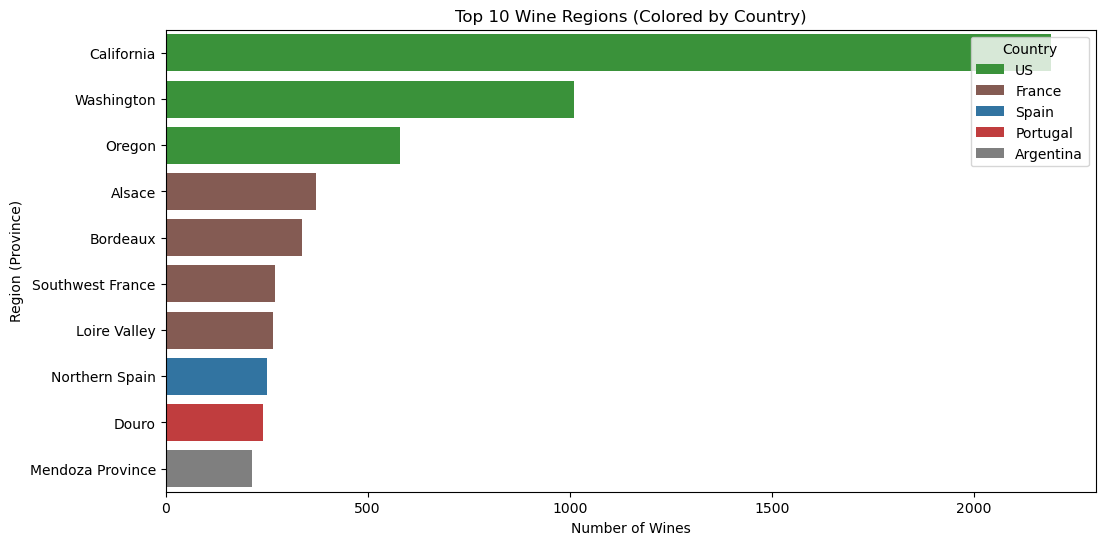

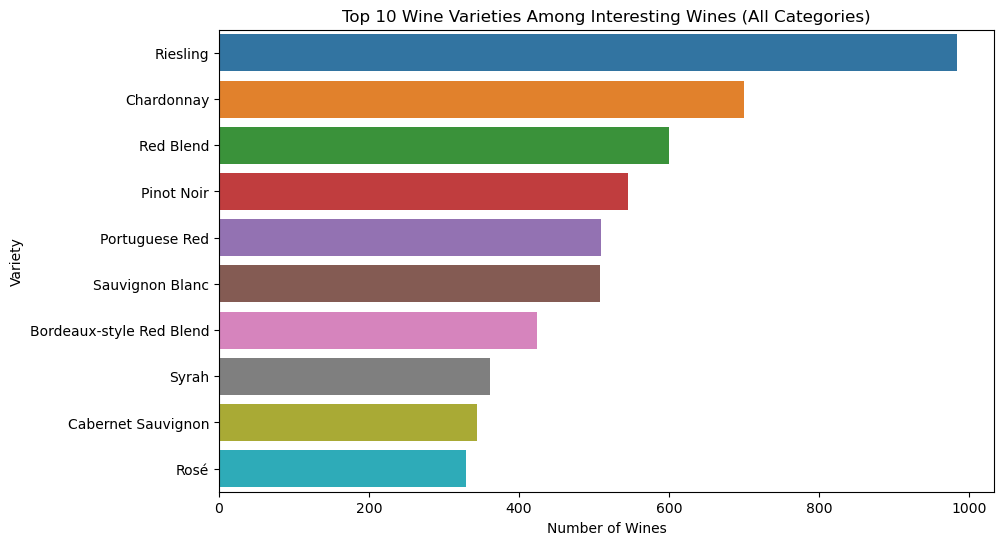

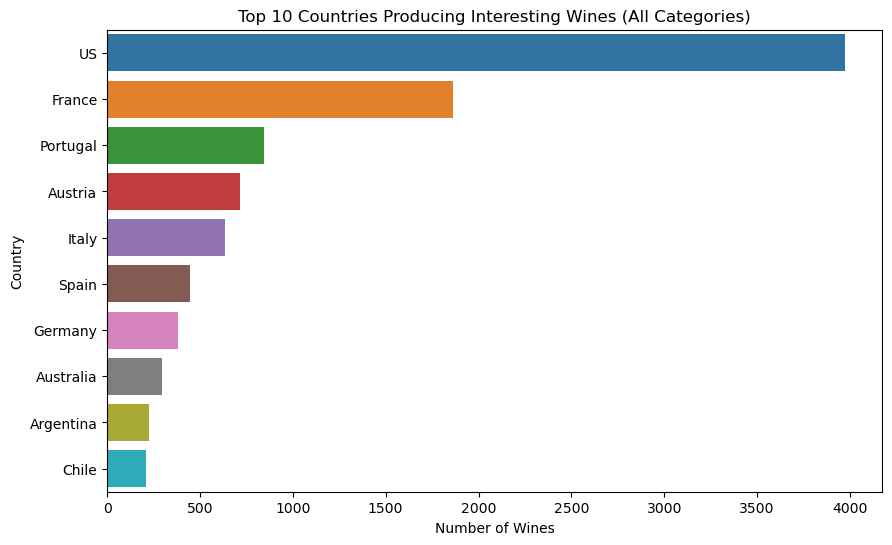

<Figure size 1200x800 with 0 Axes>

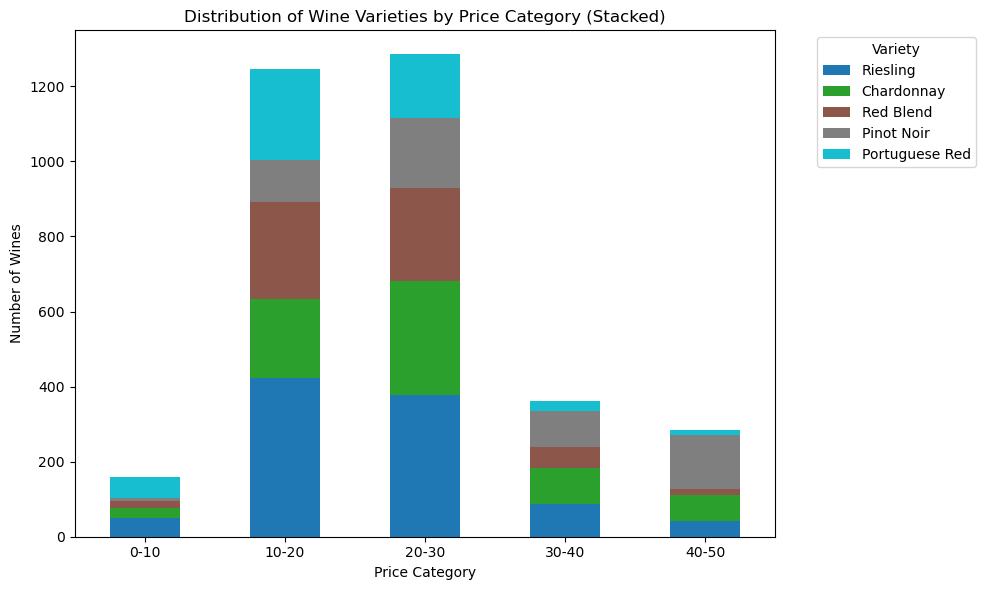

<Figure size 1200x800 with 0 Axes>

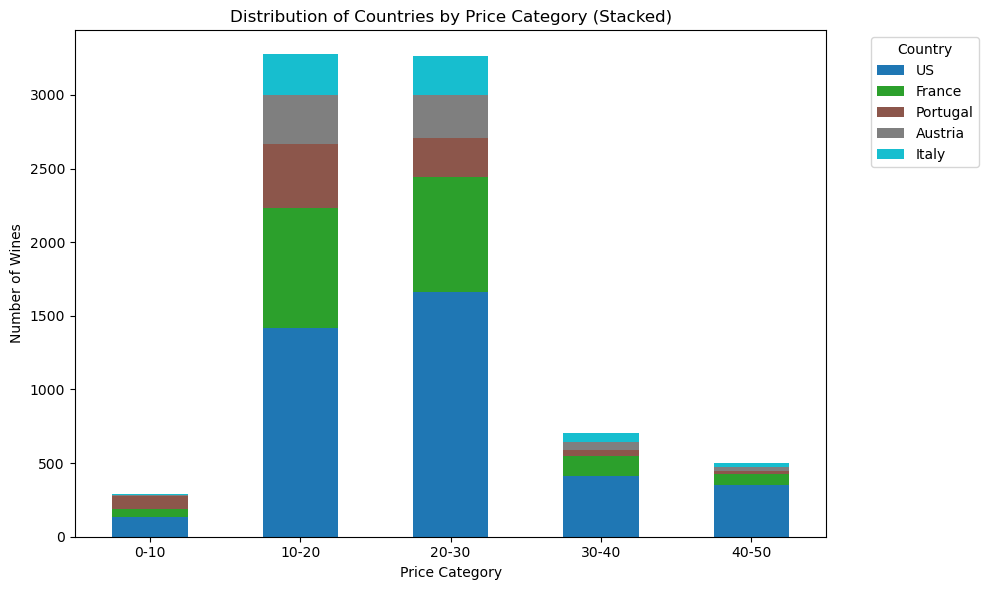

((10116, 7),
                variety       country                 province  \
 84  Cabernet Sauvignon  South Africa  Simonsberg-Stellenbosch   
 86            Riesling       Germany              Rheinhessen   
 88  Cabernet Sauvignon            US               California   
 89    Portuguese White      Portugal               Alentejano   
 93            Riesling       Germany                    Mosel   
 
                      winery  price  points  \
 84                  Delheim   30.0    91.0   
 86  Weingut Liebfrauenstift   16.0    91.0   
 88                Yardstick   25.0    91.0   
 89           Herdade Grande   30.0    91.0   
 93               Carl Graff   14.0    91.0   
 
                               expert wine description  
 84  A Cabernet-dominated (98%) wine, which boasts ...  
 86  Crisp, pristine peach and apricot notes resona...  
 88  This wine shows off Yountville fruit at its fi...  
 89  This bottling shows a rich, wood-aged wine, fu...  
 93  Approachably fr

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'
wine_data = pd.read_csv(file_path + 'cleaned_wine_data_price_max=50.csv')
print(wine_data.shape)

# Segment the data into $10 price categories
wine_data['price_category'] = pd.cut(wine_data['price'], bins=[0, 10, 20, 30, 40, 50], labels=['0-10', '10-20', '20-30', '30-40', '40-50'])

# Calculate Z-score for ratings within each price category
wine_data['rating_zscore'] = wine_data.groupby('price_category')['points'].transform(lambda x: (x - x.mean()) / x.std())

# Fit a linear regression model (price vs rating)
X = wine_data[['price']]
y = wine_data['points']

model = LinearRegression()
model.fit(X, y)

# Calculate residuals (difference between predicted rating and actual rating)
wine_data['predicted_points'] = model.predict(X)
wine_data['residuals'] = wine_data['points'] - wine_data['predicted_points']

# Apply Isolation Forest for anomaly detection
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
wine_data['anomaly'] = isolation_forest.fit_predict(wine_data[['price', 'points']])

# Refine the criteria: Z-score > 1 and residuals > 1 (strict filtering)
interesting_wines = wine_data[(wine_data['rating_zscore'] > 1) & (wine_data['residuals'] > 1) & (wine_data['anomaly'] == 1)]

# Display the refined interesting wines
print(f"Interesting wines: {interesting_wines.shape}")

# Color-coding regions by country (for region bar plot)
palette = sns.color_palette('tab10', n_colors=interesting_wines['country'].nunique())
country_palette = dict(zip(interesting_wines['country'].unique(), palette))

# Group the data by province and count the corresponding countries
top_regions = interesting_wines.groupby(['province', 'country']).size().reset_index(name='count')

# Select the top 10 regions based on counts
top_regions = top_regions.nlargest(10, 'count')

# Plot the regions with colors based on their countries
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='province', hue='country', data=top_regions, palette=country_palette, dodge=False)
plt.title('Top 10 Wine Regions (Colored by Country)')
plt.xlabel('Number of Wines')
plt.ylabel('Region (Province)')
plt.legend(title='Country', loc='upper right')
plt.show()

# Overall distribution of top wine varieties
plt.figure(figsize=(10, 6))
variety_count = interesting_wines['variety'].value_counts().nlargest(10)
sns.barplot(x=variety_count.values, y=variety_count.index)
plt.title('Top 10 Wine Varieties Among Interesting Wines (All Categories)')
plt.xlabel('Number of Wines')
plt.ylabel('Variety')
plt.show()

# Overall distribution of top countries
plt.figure(figsize=(10, 6))
country_count = interesting_wines['country'].value_counts().nlargest(10)
sns.barplot(x=country_count.values, y=country_count.index)
plt.title('Top 10 Countries Producing Interesting Wines (All Categories)')
plt.xlabel('Number of Wines')
plt.ylabel('Country')
plt.show()

# Stacked bar plot for wine varieties by price category
plt.figure(figsize=(12, 8))
varieties_by_price = interesting_wines.groupby(['price_category', 'variety']).size().unstack(fill_value=0)

# Limit to top 5 varieties for easier visualization
top_varieties = variety_count.index[:5]
varieties_by_price[top_varieties].plot(kind='bar', stacked=True, colormap='tab10', figsize=(10, 6))
plt.title('Distribution of Wine Varieties by Price Category (Stacked)')
plt.xlabel('Price Category')
plt.ylabel('Number of Wines')
plt.xticks(rotation=0)
plt.legend(title='Variety', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Stacked bar plot for countries by price category
plt.figure(figsize=(12, 8))
countries_by_price = interesting_wines.groupby(['price_category', 'country']).size().unstack(fill_value=0)

# Limit to top 5 countries for easier visualization
top_countries = country_count.index[:5]
countries_by_price[top_countries].plot(kind='bar', stacked=True, colormap='tab10', figsize=(10, 6))
plt.title('Distribution of Countries by Price Category (Stacked)')
plt.xlabel('Price Category')
plt.ylabel('Number of Wines')
plt.xticks(rotation=0)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save the filtered data
interesting_wines.to_csv(file_path + 'interesting_wines.csv', index=False)

# Save more concise data selection for the app
# Removing unnecessary columns and renaming description column
columns_to_remove = ['taster_name', 'price_category', 'rating_zscore', 'predicted_points', 'residuals', 'anomaly']
concise_wine_data = interesting_wines.drop(columns=columns_to_remove)
concise_wine_data = concise_wine_data.rename(columns={"description": "expert wine description"})

# Define the preferred column order
column_order = ['variety', 'country', 'province', 'winery', 'price', 'points', 'expert wine description']

# Reorder the concise dataset according to this new order
concise_wine_data = concise_wine_data[column_order]

# Save the concise dataset
concise_wine_data.to_csv(file_path + 'concise_interesting_wines.csv', index=False)

# Display the shape and first few rows of the concise data
concise_wine_data.shape, concise_wine_data.head()
